In [302]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog
from skimage import data, exposure
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize

from keras.preprocessing import image

import pandas as pd

# Hide all warnings
import warnings
warnings.filterwarnings('ignore')

import nltk

df = pd.read_csv("../visualstories_edfest_2016_twitter_xmedia.csv", sep=';', encoding="utf-8")

data = np.array([df.get("text").values, df.get("image-url").values])
tweets = data[0]
images = data[1]

# Bad resulsts
#from nltk.tokenize import TreebankWordTokenizer
#tknzr = TreebankWordTokenizer()

# Good results but doesn't have method to remove links
#from nltk.tokenize import TweetTokenizer
#tknzr = TweetTokenizer(strip_handles=True, preserve_case=False)

# Very Good Resulsts, probably because urls and handles are removed
from tokenizer import tokenizer
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

def k_neighbours(q, X, metric="euclidean", k=10):
    # Check pairwise_distances function docs: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances
    dists = pairwise_distances(q, X, metric=metric)
    
    # Dists gets a shape 1 x NumDocs. Convert it to shape NumDocs (i.e. drop the first dimension)
    dists = np.squeeze(dists)
    sorted_indexes = np.argsort(dists)
    
    return sorted_indexes[:k], dists[sorted_indexes[:k]]

def init_bow(texts, tknzr):
    tknzr = tokenizer.TweetTokenizer(preserve_handles=False, preserve_case=False, preserve_url=False)
    vectorizer = CountVectorizer(stop_words="english", min_df=3, binary=False, tokenizer=tknzr.tokenize)
    texts_bow = vectorizer.fit_transform(tweets)
    vocabulary = vectorizer.vocabulary_
    #print("Vocabulary size: {}".format(len(vocabulary)))
    texts_bow = normalize(texts_bow, norm="l2")
    
    return texts_bow

def bow_query(query):
    # Transform query in a BoW representation
    query_bow = vectorizer.transform([query])
    query_bow = normalize(query_bow, norm="l2")
    
    return query_bow

def center_crop_image(im, size=224):

    if len(im.shape) >= 3 and im.shape[2] == 4: # Remove the alpha channel when present
        im = im[:, :, 0:3]

    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = resize(image=im, output_shape=(224, int(w * 224 / h)))
    else:
        im = resize(im, (int(h * 224 / w), 224))

    # Center crop to 224x224
    h, w, _ = im.shape
    im = im[h // 2 - 112:h // 2 + 112, w // 2 - 112:w // 2 + 112]
    
    return im

def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,6)):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        img = center_crop_image(imread(list_of_images[i]))
        plt.imshow(img)
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

def print_results(results):
    for r in results:
        print("{0}".format(r[2]))
        img = imread(r[3].replace('https://pbs.twimg.com/media/', '../images/'))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    # results = np.array(results)
    # grid_display([r.replace('https://pbs.twimg.com/media/', '../images/') for r in results[:,3]], results[:,2], 1)

In [303]:
texts_bow = init_bow(tweets, tknzr)

query = "Edinburgh Castle is one of the main attractions"
query_bow = bow_query(query)

k_nearest_indexes, k_nearest_dists = k_neighbours(q=query_bow, X=texts_bow, metric="cosine", k=10)

results = list(zip(k_nearest_indexes,k_nearest_dists, [tweets[i] for i in k_nearest_indexes],[images[i] for i in k_nearest_indexes]))

# Original Query

In [304]:
print("{0}\n".format(query))

Edinburgh Castle is one of the main attractions



# Results

Edinburgh castle overlooking grassmarket #edfringe pic.twitter.com/K4M7fmcPXe


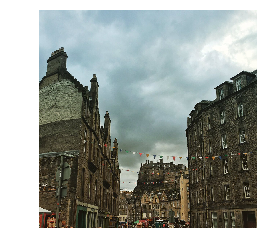

Castle show kicks off Edinburgh festival http://dlvr.it/LzMv9x pic.twitter.com/L4gugHwK0p


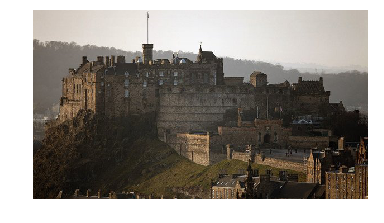

Beautiful Edinburgh Castle  #edfringe #scotlandpic.twitter.com/BncX39N619


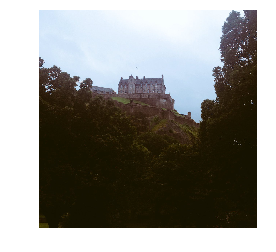

This week's cultural light show courtesy of Edinburgh Castle #edfest pic.twitter.com/egGaouUhpD


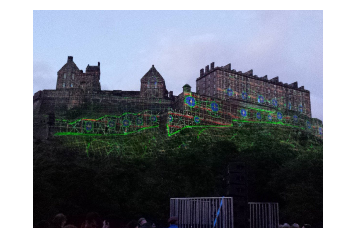

Edinburgh Castle #DeepTime #Edinburgh #edfest via http://ift.tt/1qC8Qxm pic.twitter.com/qVGNuCTDlc


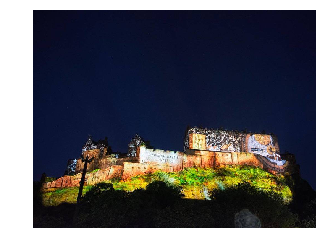

Photo from digital light show @ Edinburgh Castle last night marking the opening of 2016 Edinburgh Festival #DeepTimepic.twitter.com/bVoSjcAP1u


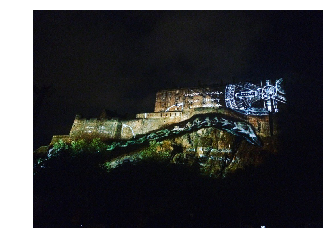

All done for 2016 #EdFringe pic.twitter.com/bPdlqYo5yB – em Edinburgh Castle


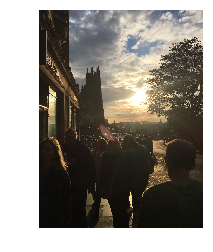

Good but cold times @EdinburghTattoo The castle looked a wee bit like wedding cake. @edinburghfest pic.twitter.com/8wHjFSbHOk – em Edinburgh Castle


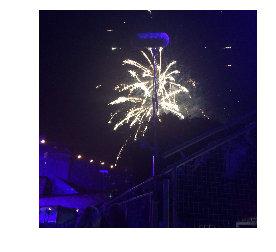

Fireworks at Edinburgh Castle end ace first day at #edfest with @thomasfoster_ https://instagram.com/p/BI8cPXVBA7F/ pic.twitter.com/YjDbvvPcra


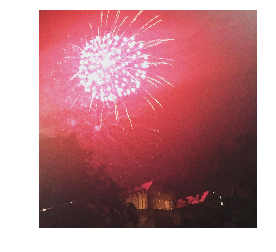

Waiting for the Deep Time opening event for Edinburgh Festival 2016 #deeptime #EdinburghFestival pic.twitter.com/4Lssa96txA – em Edinburgh Castle


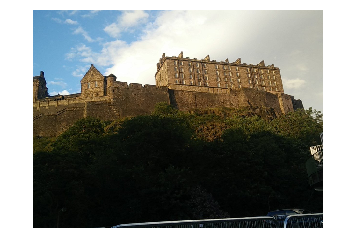

In [305]:
print_results(results)